# Training and testing Multi-label Image Classifier and using pre-trained scene classifier and a heat map generator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/Project")

Mounted at /content/gdrive


## Downloading and formatting SUN datasets

In [ ]:
# downloading data from SUN dataset
import os
synset_url = 'http://cs.brown.edu/~gmpatter/Attributes/SUNAttributeDB.tar.gz'
os.system('wget ' + synset_url)
synset_url = 'http://cs.brown.edu/~gmpatter/Attributes/SUNAttributeDB_Images.tar.gz'
os.system('wget ' + synset_url)

2

In [ ]:
import tarfile
def unpack_gz(filename):
  # open file
  file = tarfile.open(filename)
    
  # print file names
  print(file.getnames())
    
  # extract files
  file.extractall('./')
  # file.extract('sample.txt', './Destination_FolderName')
    
  # close file
  file.close()

#unpacking data from SUN DATASET
unpack_gz('SUNAttributeDB_Images.tar.gz')

#unpacking images from SUN DATASET
unpack_gz('SUNAttributeDB.tar.gz')

## Importing necessary libraries

In [ ]:
import scipy.io
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sun_dataloader import SunDataset, SUN_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# declare what device to use: gpu/cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Reading SUN Dataset

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. 

In [ ]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])


In [ ]:
ds_train = SunDataset('images/','train',train_transform)

### Loading Validation Data

Loading the validation data for the SUN dataset.

In [ ]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [ ]:
ds_val = SunDataset('images/','val',test_transform)

### Visualizing the Data

### Displaying the sorted distribution of image number per attribute in SUN Database

In [ ]:
labels_mat = scipy.io.loadmat('./SUNAttributeDB/attributeLabels_continuous.mat')
attrib_presence = labels_mat['labels_cv']  # 14340 images x 102 attributes
attrib_presence = (attrib_presence > 1/3).astype(int)   # if two out of three voted that there is an attribute in the image, we will consider that this is true

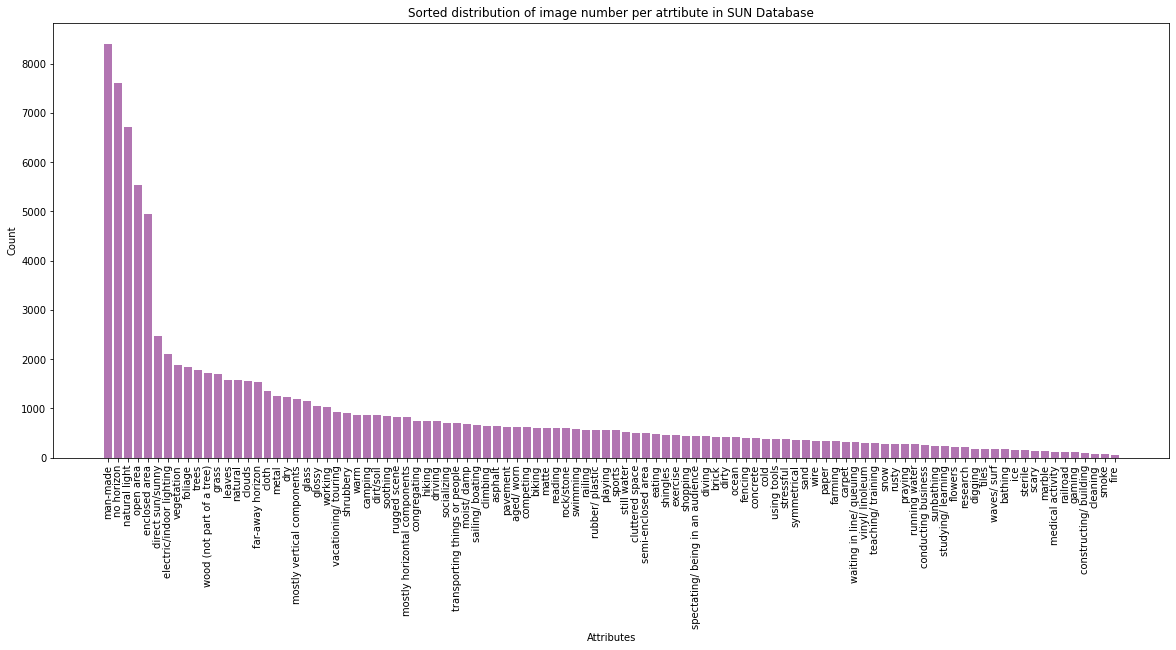

In [ ]:
attribute_numbers = np.sum(attrib_presence, axis = 0)
indices = np.argsort(attribute_numbers)[::-1]
height = [attribute_numbers[i] for i in indices]
bars = [SUN_CLASSES[i] for i in indices]
x_pos = np.arange(len(bars))
 
# Create bars and choose color
plt.figure(figsize=(20, 8))
plt.bar(x_pos, height, color = (0.5,0.1,0.5,0.6))

# Add title and axis names
plt.title('Sorted distribution of image number per atrtibute in SUN Database')
plt.xlabel('Attributes')
plt.ylabel('Count')
 
# Create names on the x axis
plt.xticks(x_pos, bars, rotation='vertical')

# Show graph
plt.show()

### Displaying some of the images and the attributes that are present in these images

In [ ]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('images/', ds_train.names[idx])
    img = Image.open(_imgpath).convert('RGB')
    
    draw = ImageDraw.Draw(img)
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

    attributes = ds_train.labels[idx]
    present_indices = []
    for i, is_present in enumerate(ds_train.labels[idx]):
      if is_present > 0:
        present_indices.append(i)
    plt.title("Attributes for the image below are: \n" + ", ".join([SUN_CLASSES[idx] for idx in present_indices]), pad = 5, fontdict={'fontsize': 14})

Output hidden; open in https://colab.research.google.com to view.

# Classification

In [ ]:
# declare what device to use: gpu/cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [ ]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [ ]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,102))
        y_score = np.zeros((0,102))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        for i in range(y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(SUN_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

In [ ]:
# plot functions
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    
def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()
    

## Training the network 

In [ ]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
        scheduler.step()
    
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

## Training with pretrained DenseNet with 201 layers

In [ ]:
num_epochs = 40
test_frequency = 5

# Load Pretrained DenseNet
classifier = torchvision.models.densenet201(pretrained=True)
classifier.classifier = nn.Linear(1920, 102)  
classifier = classifier.to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.1, momentum=0.9)
decay_rate = 0.97
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
criterion = nn.MultiLabelSoftMarginLoss()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [ ]:
classifier, train_losses, val_losses, train_mAPs, val_mAPs = train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)

Starting epoch number 1
Loss for Training on Epoch 1 is 0.14774060249328613
-------  Class: driving          AP:   0.7346  -------
-------  Class: biking           AP:   0.6716  -------
-------  Class: transporting things or people     AP:   0.6077  -------
-------  Class: sunbathing       AP:   0.2489  -------
-------  Class: vacationing/ touring     AP:   0.3861  -------
-------  Class: hiking           AP:   0.6272  -------
-------  Class: climbing         AP:   0.6765  -------
-------  Class: camping          AP:   0.7205  -------
-------  Class: reading          AP:   0.4759  -------
-------  Class: studying/ learning     AP:   0.5221  -------
-------  Class: teaching/ training     AP:   0.3831  -------
-------  Class: research         AP:   0.3135  -------
-------  Class: diving           AP:   0.4898  -------
-------  Class: swimming         AP:   0.7288  -------
-------  Class: bathing          AP:   0.3474  -------
-------  Class: eating           AP:   0.4326  -------
-------

In [ ]:
torch.save(classifier.state_dict(), './sun_attribute_classifier.pth')

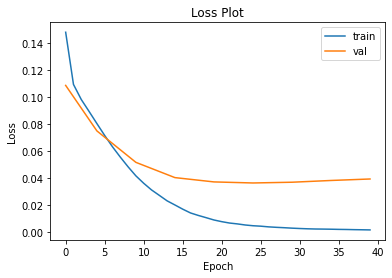

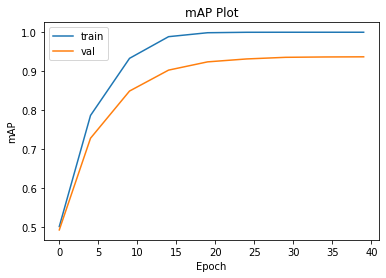

In [ ]:
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)

## Testing

In [ ]:
ds_test = SunDataset('images/','test', test_transform)
test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

In [ ]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)
print("Test mAP: ", mAP_test)

-------  Class: driving          AP:   0.9876  -------
-------  Class: biking           AP:   0.9742  -------
-------  Class: transporting things or people     AP:   0.9460  -------
-------  Class: sunbathing       AP:   0.9251  -------
-------  Class: vacationing/ touring     AP:   0.9345  -------
-------  Class: hiking           AP:   0.9697  -------
-------  Class: climbing         AP:   0.9732  -------
-------  Class: camping          AP:   0.9915  -------
-------  Class: reading          AP:   0.8877  -------
-------  Class: studying/ learning     AP:   0.9697  -------
-------  Class: teaching/ training     AP:   0.8502  -------
-------  Class: research         AP:   0.9530  -------
-------  Class: diving           AP:   0.9667  -------
-------  Class: swimming         AP:   0.9456  -------
-------  Class: bathing          AP:   0.9911  -------
-------  Class: eating           AP:   0.9539  -------
-------  Class: cleaning         AP:   1.0000  -------
-------  Class: socializing 

## Attribute classifier on a sample image

In [ ]:
def format_image(x):
    scale = np.random.rand() * 2 + 0.25
    w = int(x.size[0] * scale)
    h = int(x.size[1] * scale)
    if min(w, h) < 227:
        scale = 227 / min(w, h)
        w = int(x.size[0] * scale)
        h = int(x.size[1] * scale)
    x = test_transform(x)
    x = x.view(1, 3, 227, 227)
    return x

def get_top_10_attributes(x, classifier):
    classifier.eval()
    classifier = classifier.cpu()
    logits = classifier(x)
    sorted_indices = torch.argsort(logits, descending=True)
    top_10_indices = sorted_indices.numpy()[0][:10]
    return [SUN_CLASSES[i] for i in top_10_indices]

In [ ]:
load_network_path = './sun_attribute_classifier.pth'

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    classifier = torchvision.models.densenet201()
    classifier.classifier = nn.Linear(1920, 102) 
    classifier.load_state_dict(torch.load(load_network_path, map_location=torch.device('cpu') ))

Loading saved network from ./sun_attribute_classifier.pth


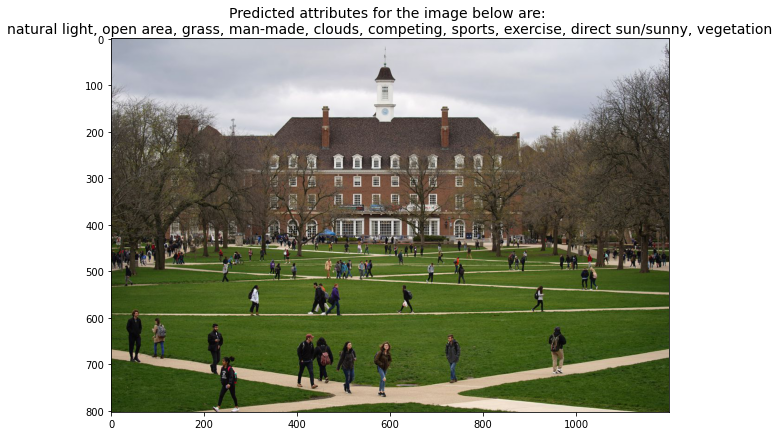

In [ ]:
img = Image.open('./university.jfif').convert('RGB')
img_formatted = format_image(img)
top_10_attributes = get_top_10_attributes(img_formatted, classifier)

draw = ImageDraw.Draw(img)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.title("Predicted attributes for the image below are: \n" + ", ".join(top_10_attributes), pad = 5, fontdict={'fontsize': 14});

## Predicting the scene of an input image using the pre-trained scene classifier and outputting a heat map for an input image

In [ ]:
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import cv2
from run_all_classifiers import load_labels, load_model, returnTF, load_attributes_classifier, returnCAM, features_blobs

--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.700 -> campus
0.062 -> courthouse
0.052 -> embassy
0.030 -> golf_course
0.022 -> lawn


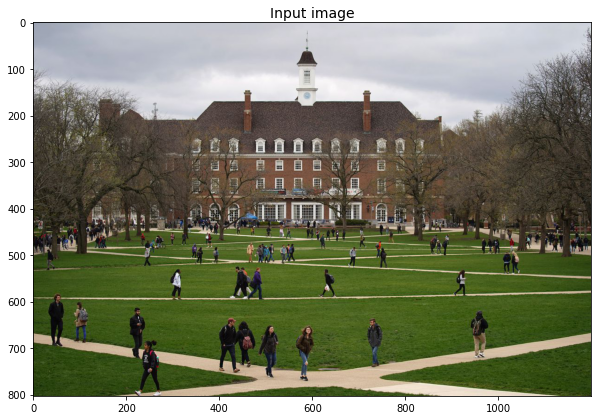

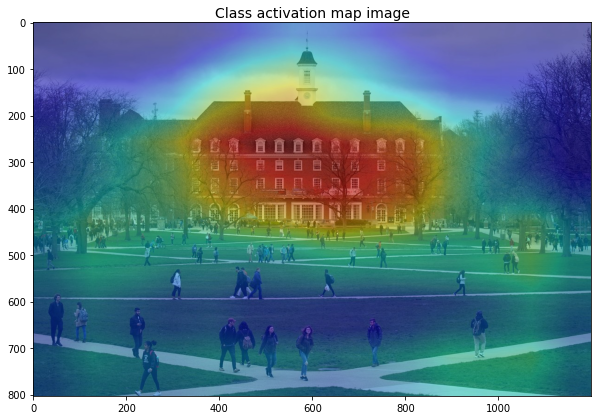

In [ ]:
# load the test image
img_name = 'university.jfif'
img = Image.open(img_name)
draw = ImageDraw.Draw(img)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.title("Input image", pad = 5, fontdict={'fontsize': 14});
input_img = V(tf(img).unsqueeze(0))

# load the labels
classes, labels_IO, labels_attribute = load_labels()
# load the model
model = load_model()
# load the transformer
tf = returnTF() # image transformer
# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])
# render the CAM and output
img = cv2.imread(img_name)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('cam.jpg', result)

cam_name = 'cam.jpg'
cam_img = Image.open(cam_name)
draw = ImageDraw.Draw(cam_img)
plt.figure(figsize = (10,10))
plt.imshow(cam_img)
plt.title("Class activation map image", pad = 5, fontdict={'fontsize': 14});